# Volatility Arbitrage Strategy

In [1]:
# import necessary libraries
import pandas as pd

# import class object under Code folder
from Code.data_cleaning import data_cleaning
from Code.implied_vol import BS_implied_vol
from Code.fit_bs import fit_BS

## Data Cleaning

- retrieve spx option data from Bloomberg
- retrieve spx index data from yhoo finance
- clean data
  - unnecessary rows and columns
  - option ticker breakdown
  - expiration date format
  - keep options with certain expiration date which have more than 10 implied volatility
  - save the term structure of options
  - use the mid price of bid and ask as the option price
  - only use SPX data not SPXW data


In [2]:
raw_data = pd.read_csv('./Public/data/option_price/20230901/spx_option_0901.csv')
option_data = data_cleaning(raw_data).format_data()
option_data = data_cleaning(option_data).check_iv_number()
spx_data = data_cleaning(option_data).get_spx_hist('2021-09-01', '2023-11-13')
option_price = data_cleaning(option_data).extract_option_price()

display(option_data.head())
display(spx_data.head())
display(option_price.head())

,Ticker,Index,Type,Expiry,Strike,Bid,Ask,Last,Volm,IVM
0,SPX 9/15/23 C4470,SPX,C,2023-09-15,4470,66.699997,67.699997,68.380005,16.0,10.665597
1,SPX 9/15/23 C4475,SPX,C,2023-09-15,4475,62.900009,63.900009,61.449997,18.0,10.570473
2,SPX 9/15/23 C4480,SPX,C,2023-09-15,4480,59.100006,60.199997,53.169998,6.0,10.464067
3,SPX 9/15/23 C4490,SPX,C,2023-09-15,4490,52.000000,53.000000,52.119995,11.0,10.279760
4,SPX 9/15/23 C4495,SPX,C,2023-09-15,4495,48.599991,49.599991,48.669998,6.0,10.197698


,Open
Date,
2021-09-01,4528.799805
2021-09-02,4534.479980
2021-09-03,4532.419922
2021-09-07,4535.379883
2021-09-08,4518.089844


,Index,Strike,Expiry,c,p
0,SPX,4470,2023-09-15,67.199997,16.199997
1,SPX,4475,2023-09-15,63.400009,17.400002
2,SPX,4480,2023-09-15,59.650002,18.649994
3,SPX,4490,2023-09-15,52.500000,21.449997
4,SPX,4495,2023-09-15,49.099991,23.000000


## Find BS Implied Volatility

- use put-call parity to calculate the risk-free rate and dividend yield for spx index option
  - for different expiration date, the implied risk-free rate are different. 
    $$
    C-P = S_0e^{-qT}-Ke^{-rT}\\
    C-P = e^{-rT}(S_0e^{(r-q)T}-K) = e^{-r}(F_{(0, T)}-K)\\
    \text{where }F_{(0,T)}:=S_0e^{(r-q)T}, \text{ which is the forward price at time 0 with maturity T. }
    $$
  - get rid of outlier and abnormal value, implied risk-free rate are the average of the rest
    $$
      r_{risk-free, implied} = \frac{1}{N}\sum_{i=1}^N r_i, \quad r_i \in [r_{min}, r_{max}]
    $$
- use Black-Scholes model to calculate the implied volatility for each option
  - Black-Scholes model using forward price, the formula is:
    $$
    C(t) = e^{-r(T-t)}(F_{(t, T)}\Phi(d_1)-K\Phi(d_2))\\
    P(t) = e^{-r(T-t)}(K\Phi(-d_2)-F_{(t, T)}\Phi(-d_1))\\
    \displaystyle\text{where }d_1 = \frac{\ln(\frac{F_{(t, T)}}{K})+\frac{1}{2}\sigma^2T}{\sigma\sqrt{T}},\quad d_2 = d_1-\sigma\sqrt{T}, \quad \phi() \text{ is the standard normal pdf}\\
    \text{and }F_{(t, T)}:=S_0e^{(r-q)(T-t)}, \text{ which is the forward price at time 0 with maturity T. }
    
    $$
  - Use bisection method to get the implied volatility.   
    $$
      \sigma_{implied}(F_{(0, T)}, K, T, r, c) = \sigma_{implied}(F_{(0, T)}, K, T, r, p)\\
    $$


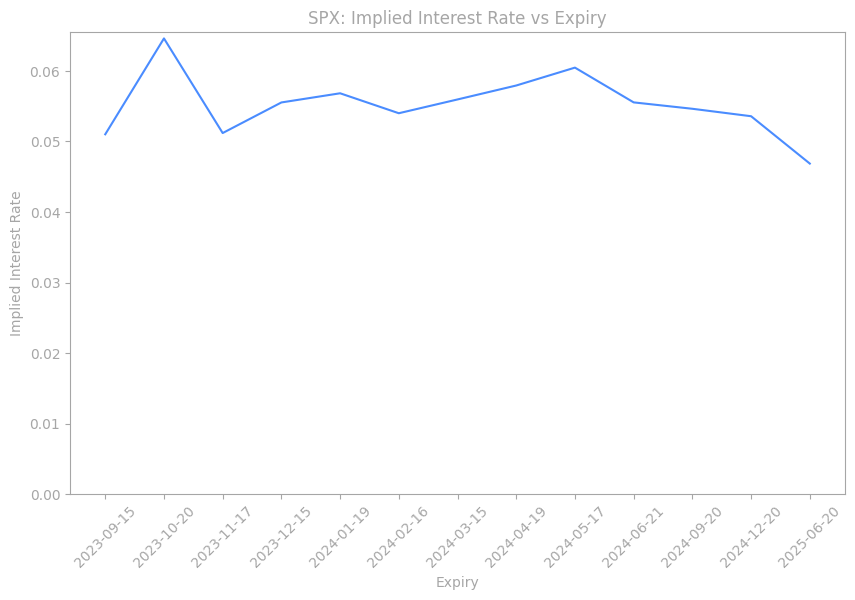

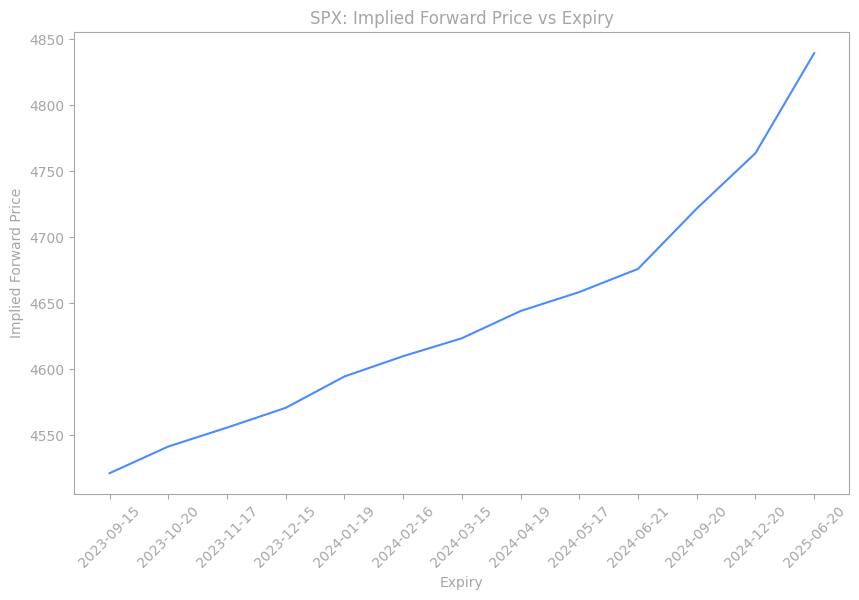

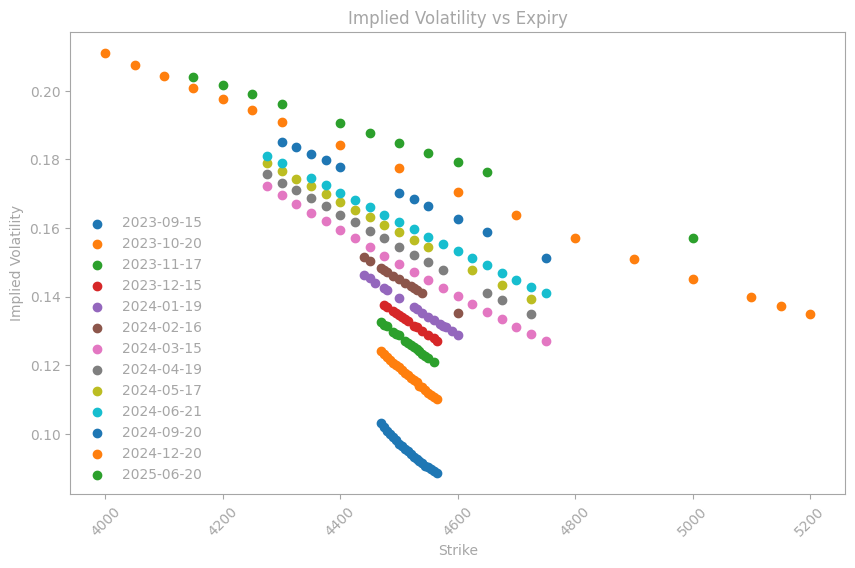

,Index,Expiry,implied_ir,implied_fwd
0,SPX,2023-09-15,0.051018,4521.108973
1,SPX,2023-10-20,0.064610,4541.316310
2,SPX,2023-11-17,0.051196,4555.638916
3,SPX,2023-12-15,0.055533,4570.635823
4,SPX,2024-01-19,0.056832,4594.397578


,4000,4050,4100,4150,4200,4250,4275,4300,4325,4350,...,4675,4700,4725,4750,4800,4900,5000,5100,5150,5200
2023-09-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-15,NaN,NaN,NaN,NaN,NaN,NaN,0.172161,0.169514,0.167037,0.164475,...,0.133388,0.131137,0.129167,0.12712,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-19,NaN,NaN,NaN,NaN,NaN,NaN,0.175833,0.173271,0.171136,0.16866,...,0.138946,NaN,0.134866,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-17,NaN,NaN,NaN,NaN,NaN,NaN,0.178907,0.176601,0.174381,0.172161,...,0.143448,NaN,0.139368,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-21,NaN,NaN,NaN,NaN,NaN,NaN,0.180871,0.178821,NaN,0.174552,...,0.14693,0.144925,0.142815,0.140915,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
implied_params = BS_implied_vol(option_price).parity_implied_params(option_data, plot_parity=False)
BS_implied_vol(option_price).plot_ir(implied_params)
BS_implied_vol(option_price).plot_fwd(implied_params)
implied_vol = BS_implied_vol(option_price).get_iv(option_data, implied_params, spx_data, plot_iv_scatter=True)

display(implied_params.head())
display(implied_vol)

## Fit BS Implied Volatility Surface


- Calculate forward moneyness for each option
  $$
  \text{forward moneyness} = \ln\left(\frac{K}{F_{(t,T)}}\right)
  $$
  - The forward price for each maturity is different. 
- calculate the implied volatility for each option using the implied volatility of the at-the-money forward option with the same expiration date
  - there is no at-the-money forward option data, therefore, fit the nearest 4 implied volatility by linear function, $f(x) = ax + b$ 
- for the same expiration date, fit the implied volatility curve against spot moneyness using function below:
  - option 1: similar to tanh function
    $$
    \sigma(x)^2 = \sigma_{atm}^2 + \delta\displaystyle\left(\frac{\tanh(\kappa x)}{\kappa}\right) + \frac{\gamma}{2}\left(\frac{\tanh(\kappa x)}{\kappa}\right)^2,\quad
    \text{where }x = \displaystyle\ln\left(\frac{K}{S}\right)
    $$
  - option 2: similar to sigmoid function
    - TBC

- for different expiration date, for same moneyness, connect the implied volatility curve using cubic spline interpolation


,2023-09-15,2023-10-20,2023-11-17,2023-12-15,2024-01-19,2024-02-16,2024-03-15,2024-04-19,2024-05-17,2024-06-21,2024-09-20,2024-12-20,2025-06-20
implied_fwd,4521.108973,4541.316310,4555.638916,4570.635823,4594.397578,4609.759777,4623.348187,4644.000761,4658.350784,4675.913084,4721.610184,4763.590394,4839.359375
4000,0.884739,0.880802,0.878033,0.875152,0.870626,0.867724,0.865174,0.861326,0.858673,0.855448,0.847169,0.839703,0.826556
4050,0.895798,0.891812,0.889008,0.886091,0.881508,0.878571,0.875989,0.872093,0.869406,0.866141,0.857758,0.850199,0.836888
4100,0.906857,0.902822,0.899984,0.897031,0.892391,0.889417,0.886803,0.882859,0.880140,0.876834,0.868348,0.860695,0.847220
4150,0.917916,0.913832,0.910959,0.907970,0.903274,0.900264,0.897618,0.893626,0.890873,0.887527,0.878937,0.871192,0.857552


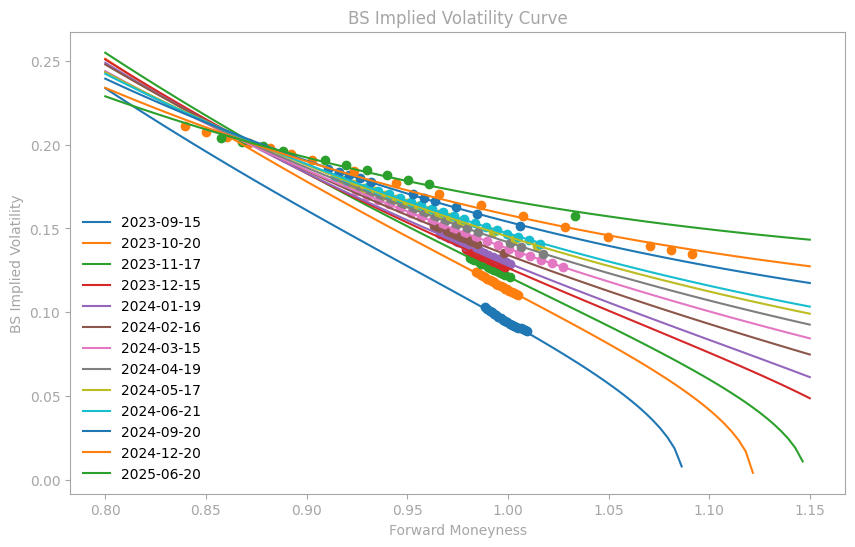

,2023-09-15,2023-10-20,2023-11-17,2023-12-15,2024-01-19,2024-02-16,2024-03-15,2024-04-19,2024-05-17,2024-06-21,2024-09-20,2024-12-20,2025-06-20
atm_vol,0.093901,0.113349,0.121431,0.126338,0.129517,0.134115,0.137969,0.141562,0.144877,0.146857,0.153322,0.159627,0.165973
delta,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,6.433480,6.214641,6.056339,5.901553,5.348170,4.725140,3.913954
kappa,2.755656,2.700000,2.700302,2.740148,2.762225,2.784934,2.700000,2.700000,2.700000,2.700000,2.700000,2.700000,2.700000
gamma,-44.446711,-43.591539,-43.597067,-44.208906,-44.549855,-44.900013,-35.055751,-33.862667,-32.999987,-32.156696,-29.139234,-25.754389,-21.323590


In [4]:
fwd_moneyness_spx = fit_BS(implied_vol, implied_params).get_fwd_mny()
display(fwd_moneyness_spx.head())
bs_iv_curve_params = fit_BS(implied_vol, implied_params).fit_BS_curve(fwd_moneyness_spx, plot_curve=True, method='tanh')
display(bs_iv_curve_params.T)

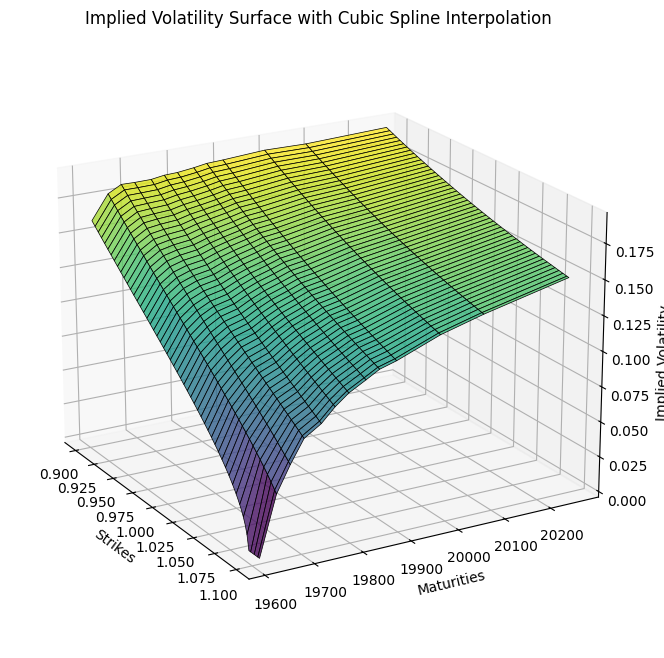

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from scipy.interpolate import CubicSpline

# Assuming bs_iv_curve_params is your DataFrame with parameters
# Replace this with your actual DataFrame
# bs_iv_curve_params = ...

# Convert date strings to numeric values
maturities_numeric = date2num(bs_iv_curve_params.index)

# Create a meshgrid for strikes and maturities
strikes = np.linspace(0.9, 1.1, 100)
X, Y = np.meshgrid(strikes, maturities_numeric)

# Function to calculate implied volatility using the parametric model
def implied_vol_curve(x, atm_vol, delta, kappa, gamma):
    y = atm_vol**2 + delta * (np.tanh(kappa * x) / kappa) + 0.5 * gamma * (np.tanh(kappa * x) / kappa)**2
    y = np.sqrt(y)
    return y

# Initialize an empty array to store implied volatility values
implied_vol_values = np.zeros_like(X)

# Loop over each expiry and calculate implied volatility values
for i, expiry in enumerate(bs_iv_curve_params.index):
    # Extract parameters for the current expiry
    params = bs_iv_curve_params.loc[expiry].values
    atm_vol = params[0]

    # Calculate implied volatility values for the current expiry
    implied_vol_values[i, :] = implied_vol_curve(strikes, *params)

# Fit NaN values with zero
implied_vol_values = np.nan_to_num(implied_vol_values, nan=0.0)

# Create a 1D array of unique maturities for CubicSpline
unique_maturities = np.unique(maturities_numeric)

# Initialize an empty array to store interpolated implied volatility values
interpolated_vol_values = np.zeros_like(X)

# Perform cubic spline interpolation for each strike
for i in range(len(strikes)):
    cs = CubicSpline(unique_maturities, implied_vol_values[:, i])
    interpolated_vol_values[:, i] = cs(maturities_numeric)

# Create a wireframe plot with color gradients
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, interpolated_vol_values, cmap='viridis', edgecolor='k', linewidth=0.5, alpha=0.8)

# Set labels and title
ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
ax.set_zlabel('Implied Volatility')
ax.set_title('Implied Volatility Surface with Cubic Spline Interpolation')

# Improve the viewing angle
ax.view_init(elev=20, azim=-30)

# Show the plot
plt.show()


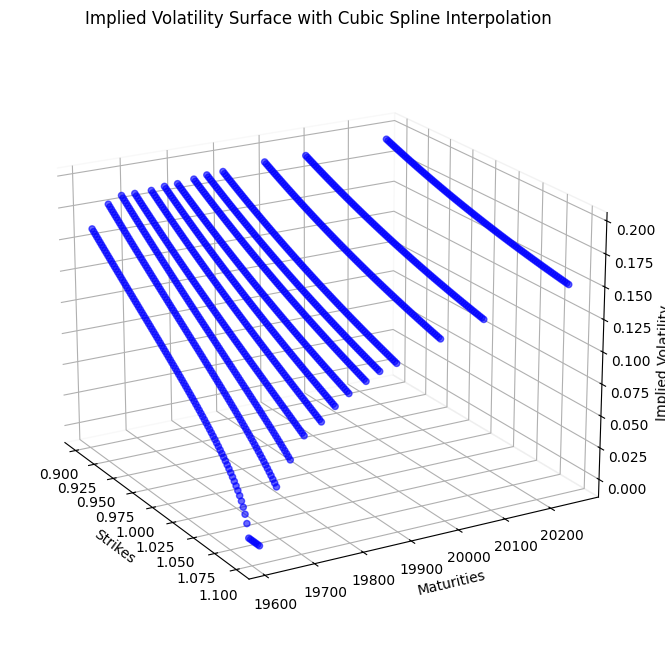

In [14]:
# Create a scatter plot with blue points
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, interpolated_vol_values, c='blue', marker='o', alpha=0.6)

# Set labels and title
ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
ax.set_zlabel('Implied Volatility')
ax.set_title('Implied Volatility Surface with Cubic Spline Interpolation')

# Improve the viewing angle
ax.view_init(elev=20, azim=-30)

# Set grey grid
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(True, color='grey', linestyle='-', linewidth=0.5, alpha=0.5)

# Show the plot
plt.show()

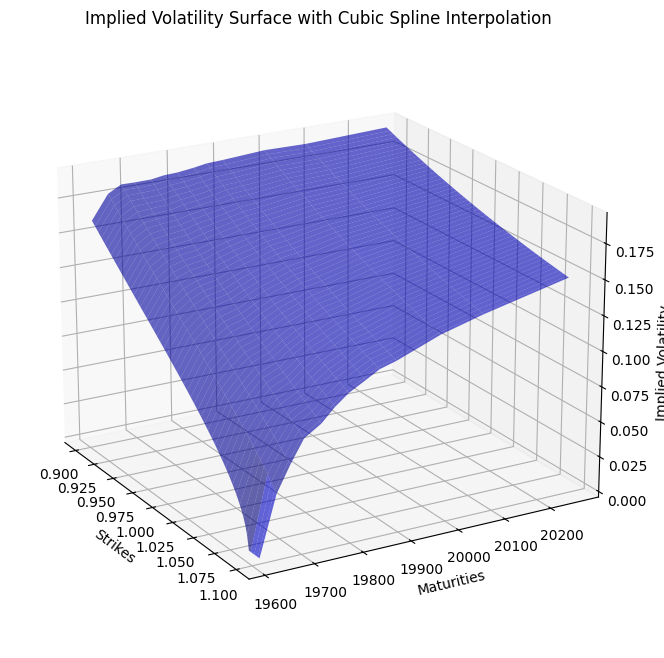

In [15]:
# Create a 3D plot with a line connecting the blue points and a grey grid
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the blue line
ax.plot_surface(X, Y, interpolated_vol_values, color='blue', alpha=0.6)

# Set labels and title
ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
ax.set_zlabel('Implied Volatility')
ax.set_title('Implied Volatility Surface with Cubic Spline Interpolation')

# Improve the viewing angle
ax.view_init(elev=20, azim=-30)

# Create a grey grid
ax.grid(True, color='grey', linestyle='-', linewidth=0.5, alpha=0.5)

# Show the plot
plt.show()


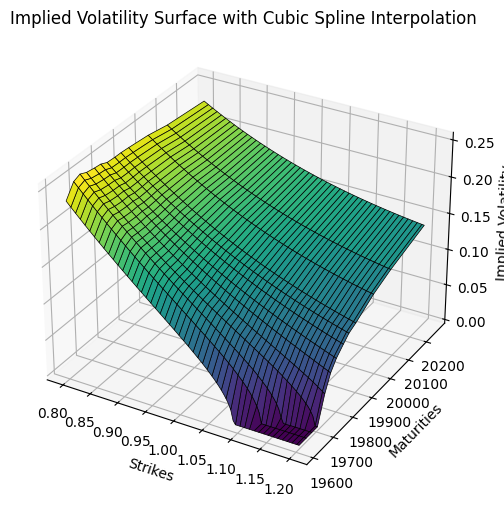

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from scipy.interpolate import CubicSpline

# Assuming bs_iv_curve_params is your DataFrame with parameters
# Replace this with your actual DataFrame
# bs_iv_curve_params = ...

# Convert date strings to numeric values
maturities_numeric = date2num(bs_iv_curve_params.index)

# Create a meshgrid for strikes and maturities
strikes = np.linspace(0.8, 1.2, 100)
X, Y = np.meshgrid(strikes, maturities_numeric)

# Function to calculate implied volatility using the parametric model
def implied_vol_curve(x, atm_vol, delta, kappa, gamma):
    y = atm_vol**2 + delta * (np.tanh(kappa * x) / kappa) + 0.5 * gamma * (np.tanh(kappa * x) / kappa)**2
    y = np.sqrt(y)
    return y

# Initialize an empty array to store implied volatility values
implied_vol_values = np.zeros_like(X)

# Loop over each expiry and calculate implied volatility values
for i, expiry in enumerate(bs_iv_curve_params.index):
    # Extract parameters for the current expiry
    params = bs_iv_curve_params.loc[expiry].values
    atm_vol = params[0]

    # Calculate implied volatility values for the current expiry
    implied_vol_values[i, :] = implied_vol_curve(strikes, *params)

# Fit NaN values with zero
implied_vol_values = np.nan_to_num(implied_vol_values, nan=0.0)

# Create a 1D array of unique maturities for CubicSpline
unique_maturities = np.unique(maturities_numeric)

# Initialize an empty array to store interpolated implied volatility values
interpolated_vol_values = np.zeros_like(X)

# Perform cubic spline interpolation for each strike
for i in range(len(strikes)):
    cs = CubicSpline(unique_maturities, implied_vol_values[:, i])
    interpolated_vol_values[:, i] = cs(maturities_numeric)

# Create a 3D plot using plot_surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, interpolated_vol_values, cmap='viridis', edgecolor='k', linewidth=0.5, antialiased=True)

# Set labels and title
ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
ax.set_zlabel('Implied Volatility')
ax.set_title('Implied Volatility Surface with Cubic Spline Interpolation')

# Show the plot
plt.show()


In [6]:
from scipy.interpolate import CubicSpline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num

# Assuming bs_iv_curve_params is your DataFrame with parameters
# Replace this with your actual DataFrame
# bs_iv_curve_params = ...

# Convert date strings to numeric values
maturities_numeric = date2num(bs_iv_curve_params.index)

# Create a meshgrid for strikes and maturities
strikes = np.linspace(0.8, 1.2, 100)
X, Y = np.meshgrid(strikes, maturities_numeric)

# Function to calculate implied volatility using the parametric model
def implied_vol_curve(x, atm_vol, delta, kappa, gamma):
    y = atm_vol**2 + delta * (np.tanh(kappa * x) / kappa) + 0.5 * gamma * (np.tanh(kappa * x) / kappa)**2
    y = np.sqrt(y)
    return y

# Initialize an empty array to store implied volatility values
implied_vol_values = np.zeros_like(X)

# Loop over each expiry and calculate implied volatility values
for i, expiry in enumerate(bs_iv_curve_params.index):
    # Extract parameters for the current expiry
    params = bs_iv_curve_params.loc[expiry].values
    atm_vol = params[0]

    # Calculate implied volatility values for the current expiry
    implied_vol_values[i, :] = implied_vol_curve(strikes, *params)

# fit call nan its previous value
implied_vol_values = np.nan_to_num(implied_vol_values, nan=0.0)
display(implied_vol_values)
# Create a 1D array of unique maturities for CubicSpline
unique_maturities = np.unique(maturities_numeric)

# Initialize an empty array to store interpolated implied volatility values
interpolated_vol_values = np.zeros_like(X)

# Perform cubic spline interpolation for each strike
for i in range(len(strikes)):
    cs = CubicSpline(unique_maturities, implied_vol_values[:, i])
    interpolated_vol_values[:, i] = cs(maturities_numeric)



array([[0.23365028, 0.2304817 , 0.22733513, ..., 0.        , 0.        ,
        0.        ],
       [0.25124258, 0.24803746, 0.24485541, ..., 0.        , 0.        ,
        0.        ],
       [0.25482576, 0.25166759, 0.24853335, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.23935122, 0.23710631, 0.23488525, ..., 0.1103009 , 0.10967295,
        0.10905492],
       [0.2338709 , 0.23184018, 0.22983246, ..., 0.12165188, 0.12114886,
        0.12065457],
       [0.22882188, 0.22710523, 0.22541006, ..., 0.13907407, 0.1387102 ,
        0.13835319]])

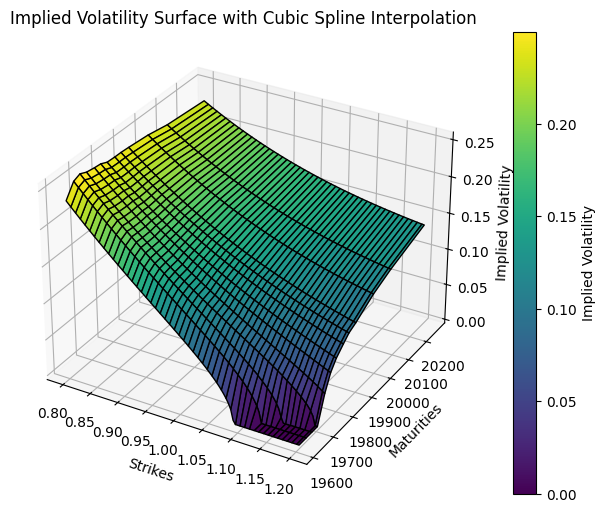

In [7]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, interpolated_vol_values, cmap='viridis', edgecolor='k')

# Add color bar which maps values to colors
cbar = fig.colorbar(surf, ax=ax, label='Implied Volatility')

# Set labels and title
ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
ax.set_zlabel('Implied Volatility')
ax.set_title('Implied Volatility Surface with Cubic Spline Interpolation')

# Show the plot
plt.show()


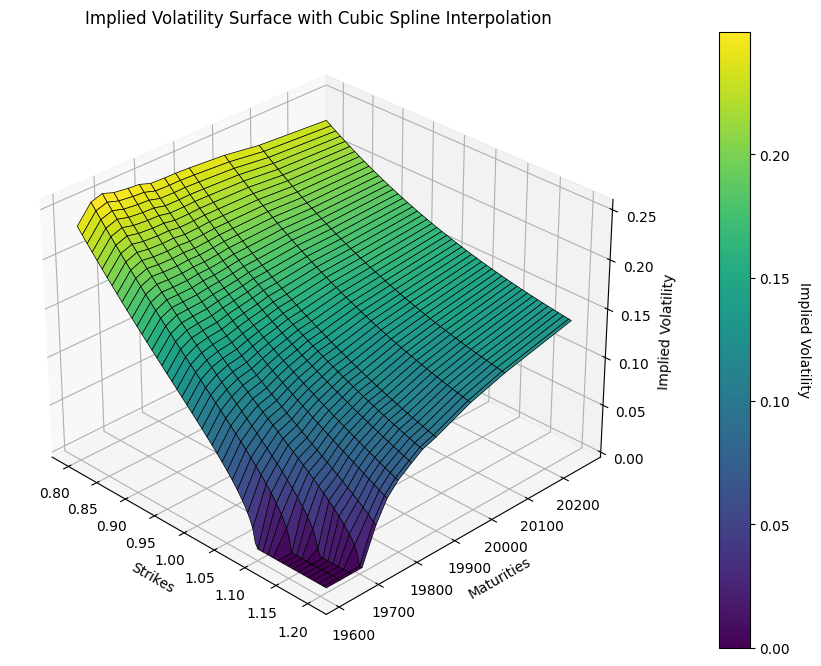

In [8]:
from mpl_toolkits.mplot3d import Axes3D

# Plot the result
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the interpolated surface with a smooth color map
surf = ax.plot_surface(X, Y, interpolated_vol_values, cmap='viridis', edgecolor='k', linewidth=0.5, antialiased=True)

# Customize the colorbar
cbar = fig.colorbar(surf, ax=ax, pad=0.1)
cbar.set_label('Implied Volatility', rotation=270, labelpad=15)

# Set labels and title
ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
ax.set_zlabel('Implied Volatility')
ax.set_title('Implied Volatility Surface with Cubic Spline Interpolation')

# Set viewing angle
ax.view_init(elev=30, azim=-45)

# Add grid lines
ax.grid(True, linestyle='dashed', linewidth=0.5, alpha=0.7)

# Show the plot
plt.show()



In [9]:
# perform cubic spline interpolation
from scipy.interpolate import CubicSpline
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# for one moneyness
fwd_mny = np.linspace(0.8, 1.2, 100)
fwd_mny = 1
# BS_implied_vol_surface = pd.DataFrame()
bs_iv_surface = np.meshgrid(fwd_mny, bs_iv_curve_params.index)
for expiry in bs_iv_curve_params.index:
    # for each expiry, with the corresponding params, calculate the implied vol
    params = bs_iv_curve_params.T[expiry]
    atm_vol = params[0]
    # BS IV curve model
    def implied_vol_curve(x, delta = params[1], kappa = params[2], gamma = params[3]):
        y = atm_vol**2 + delta * (np.tanh(kappa * x) / kappa) + 0.5 * gamma * (np.tanh(kappa * x) / kappa)**2
        y = np.sqrt(y)
        return y
    
    # store the implied vol in a meshgrid named bs_iv_surface
    Z = griddata((np.ravel(X), np.ravel(Y)), np.ravel(implied_vol_interpolated), (X, Y), method='cubic')


display(implied_vol)
    



NameError: name 'implied_vol_interpolated' is not defined

In [ ]:

fwd_mny = np.linspace(0.8, 1.2, 100)
bs_iv_surface = np.meshgrid(fwd_mny, bs_iv_curve_params.index)
display(bs_iv_surface)

[array([[0.8       , 0.8040404 , 0.80808081, ..., 1.19191919, 1.1959596 ,
         1.2       ],
        [0.8       , 0.8040404 , 0.80808081, ..., 1.19191919, 1.1959596 ,
         1.2       ],
        [0.8       , 0.8040404 , 0.80808081, ..., 1.19191919, 1.1959596 ,
         1.2       ],
        ...,
        [0.8       , 0.8040404 , 0.80808081, ..., 1.19191919, 1.1959596 ,
         1.2       ],
        [0.8       , 0.8040404 , 0.80808081, ..., 1.19191919, 1.1959596 ,
         1.2       ],
        [0.8       , 0.8040404 , 0.80808081, ..., 1.19191919, 1.1959596 ,
         1.2       ]]),
 array([['2023-09-15', '2023-09-15', '2023-09-15', ..., '2023-09-15',
         '2023-09-15', '2023-09-15'],
        ['2023-10-20', '2023-10-20', '2023-10-20', ..., '2023-10-20',
         '2023-10-20', '2023-10-20'],
        ['2023-11-17', '2023-11-17', '2023-11-17', ..., '2023-11-17',
         '2023-11-17', '2023-11-17'],
        ...,
        ['2024-09-20', '2024-09-20', '2024-09-20', ..., '2024-09-20',
  


## Convert BS Implied Volatility Surface to Local Volatility Surface

- use Dupire's formula to calculate the local volatility for each option
  $$
  \frac{\partial w}{\partial T} = v_L \left\{1 - \frac{y}{w}\frac{\partial w}{\partial y} + \frac{1}{4}\left(-\frac{1}{4}-\frac{1}{w}+\frac{y^2}{w^2}\right)\left(\frac{\partial w}{\partial y}\right)^2+\frac{1}{2}\frac{\partial^2 w}{\partial y^2}\right\}\\
  \text{where }w:=\text{ Black-Scholes implied variance},\quad y:= \ln\left(\frac{K}{F_T}\right), \quad v_L:=\text{ local volatility}
  $$

## Trading Strategy

- if the implied volatility of an option is higher than the local volatility, then sell the option

## Backtesting

# To-do List
- after delete the rows with 0 volume, the moneyness with near expiration date is close to 0, it is hard to fit the implied volatility curve
- put call parity last price in 2023-09-15, the interest rate is negative. Using last price to calculate the risk-free rate fluctuates a lot. 
- if use put-call parity to get interest rate and forward price, what is the Dupire's formula?  
- how to use spot moneyness to fit the implied volatility curve?
- implied forawrd price is not a linear line. Is there anything wrong?

# Reference

[How to Determine Implied Dividend Yield-Derivative Valuation in Excel](https://derivvaluation.medium.com/how-to-determine-implied-dividend-yield-derivative-valuation-in-excel-1078a9bc1f7f)  
[SPX vs. SPXW Options: Understanding the Key Differences](https://insideoptions.io/spx-spxw-options-differences/)  
[Cubic Spline Interpolation](https://en.wikipedia.org/wiki/Spline_interpolation#Algorithm_to_find_the_interpolating_cubic_spline)  
[Estimation of Implied Interest Rates and Dividend Yields](../volatility_arbitrage/Reference/on_a_robust_estimation_of_option-implied_interest_rates_and_dividend_yields.pdf)  
[Put-Call-Forward Parity](https://analystnotes.com/cfa-study-notes-explain-put-call-forward-parity-for-european-options.html)  
[At-The-Money-Forward option approximation](https://quant.stackexchange.com/questions/35433/at-the-money-forward-option-approximation)  
[What is forward moneyness and how to calculate it?](https://quant.stackexchange.com/questions/43596/what-is-forward-moneyness-and-how-to-calculate-it)  
[At-The-Money Forward](https://www.fincyclopedia.net/derivatives/a/at-the-money-forward)  
[Sigmoid function详解](https://zhuanlan.zhihu.com/p/108641430)  
[Cubic Spline Interpolation](https://math.libretexts.org/Bookshelves/Applied_Mathematics/Numerical_Methods_(Chasnov)/05%3A_Interpolation/5.03%3A_Cubic_Spline_Interpolation)  
[scipy.interpolate.CubicSpline](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html)